<a href="https://colab.research.google.com/github/ShauryaWadehra/object_detection_stuff/blob/main/regionproposal_obj_det.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 516.2 MB 4.4 kB/s 
     |████████████████████████████████| 454 kB 44.8 MB/s 
     |████████████████████████████████| 3.0 MB 42.4 MB/s 
     |████████████████████████████████| 26.1 MB 32.4 MB/s 
     |████████████████████████████████| 2.9 MB 42.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Unin

In [ ]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/region-proposal-object-detection/region-proposal-object-detection.zip
!unzip -qq region-proposal-object-detection.zip
%cd region-proposal-object-detection

--2022-09-11 07:10:32--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/region-proposal-object-detection/region-proposal-object-detection.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.218.132.81
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.218.132.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 280010 (273K) [binary/octet-stream]
Saving to: ‘region-proposal-object-detection.zip’

region-proposal-obj 100%[===================>] 273.45K  1.15MB/s    in 0.2s    

2022-09-11 07:10:33 (1.15 MB/s) - ‘region-proposal-object-detection.zip’ saved [280010/280010]

/content/region-proposal-object-detection


In [15]:
# import the necessary packages
from matplotlib import pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import argparse
import cv2

In [14]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# if the bounding boxes are integers, convert them to floats -- this
	# is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes
	pick = []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	# compute the area of the bounding boxes and grab the indexes to sort
	# (in the case that no probabilities are provided, simply sort on the
	# bottom-left y-coordinate)
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = y2

	# if probabilities are provided, sort on them instead
	if probs is not None:
		idxs = probs

	# sort the indexes
	idxs = np.argsort(idxs)

	# keep looping while some indexes still remain in the indexes list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the index value
		# to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the largest (x, y) coordinates for the start of the bounding
		# box and the smallest (x, y) coordinates for the end of the bounding
		# box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]

		# delete all indexes from the index list that have overlap greater
		# than the provided overlap threshold
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	# return only the bounding boxes that were picked
	return boxes[pick].astype("int")

In [ ]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [ ]:
def selective_search(image, method="fast"):
	# initialize OpenCV's selective search implementation and set the
	# input image
	ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
	ss.setBaseImage(image)

	# check to see if we are using the *fast* but *less accurate* version
	# of selective search
	if method == "fast":
		ss.switchToSelectiveSearchFast()

	# otherwise we are using the *slower* but *more accurate* version
	else:
		ss.switchToSelectiveSearchQuality()

	# run selective search on the input image
	rects = ss.process()

	# return the region proposal bounding boxes
	return rects

In [ ]:
args = {
	"image": "beagle.png",
	"method": "fast",
	"conf": 0.9,
	"filter": "beagle"
}

In [ ]:
# grab the label filters command line argument
labelFilters = args["filter"]

# if the label filter is not empty, break it into a list
if labelFilters is not None:
	labelFilters = labelFilters.lower().split(",")

In [ ]:
# load ResNet from disk (with weights pre-trained on ImageNet)
print("[INFO] loading ResNet...")
model = ResNet50(weights="imagenet")

# load the input image from disk and grab its dimensions
image = cv2.imread(args["image"])
(H, W) = image.shape[:2]

[INFO] loading ResNet...
102973440/102967424 [==============================] - 2s 0us/step


In [ ]:
# run selective search on the input image
print("[INFO] performing selective search with '{}' method...".format(
	args["method"]))
rects = selective_search(image, method=args["method"])
print("[INFO] {} regions found by selective search".format(len(rects)))

# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []

[INFO] performing selective search with 'fast' method...
[INFO] 922 regions found by selective search


In [ ]:
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects:
	# if the width or height of the region is less than 10% of the
	# image width or height, ignore it (i.e., filter out small
	# objects that are likely false-positives)
	if w / float(W) < 0.1 or h / float(H) < 0.1:
		continue

	# extract the region from the input image, convert it from BGR to
	# RGB channel ordering, and then resize it to 224x224 (the input
	# dimensions required by our pre-trained CNN)
	roi = image[y:y + h, x:x + w]
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, (224, 224))

	# further preprocess by the ROI
	roi = img_to_array(roi)
	roi = preprocess_input(roi)

	# update our proposals and bounding boxes lists
	proposals.append(roi)
	boxes.append((x, y, w, h))

In [ ]:
# convert the proposals list into NumPy array and show its dimensions
proposals = np.array(proposals)
print("[INFO] proposal shape: {}".format(proposals.shape))

# classify each of the proposal ROIs using ResNet and then decode the
# predictions
print("[INFO] classifying proposals...")
preds = model.predict(proposals)
preds = imagenet_utils.decode_predictions(preds, top=1)

# initialize a dictionary which maps class labels (keys) to any
# bounding box associated with that label (values)
labels = {}

[INFO] proposal shape: (534, 224, 224, 3)
[INFO] classifying proposals...
40960/35363 [==================================] - 0s 0us/step


In [ ]:
# loop over the predictions
for (i, p) in enumerate(preds):
	# grab the prediction information for the current region proposal
	(imagenetID, label, prob) = p[0]

	# only if the label filters are not empty *and* the label does not
	# exist in the list, then ignore it
	if labelFilters is not None and label not in labelFilters:
		continue

	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
	if prob >= args["conf"]:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
		(x, y, w, h) = boxes[i]
		box = (x, y, x + w, y + h)

		# grab the list of predictions for the label and add the
		# bounding box + probability to the list
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L

[INFO] showing results for 'beagle'


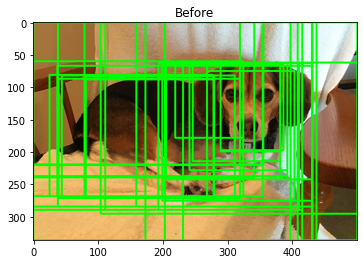

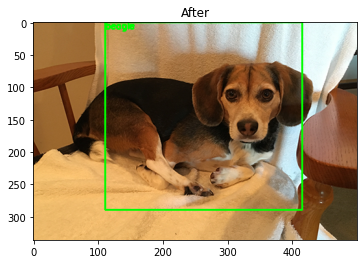

In [16]:
# loop over the labels for each of detected objects in the image
for label in labels.keys():
	# clone the original image so that we can draw on it
	print("[INFO] showing results for '{}'".format(label))
	clone = image.copy()

	# loop over all bounding boxes for the current label
	for (box, prob) in labels[label]:
		# draw the bounding box on the image
		(startX, startY, endX, endY) = box
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)

	# show the results *before* applying non-maxima suppression, then
	# clone the image again so we can display the results *after*
	# applying non-maxima suppression
	plt_imshow("Before", clone)
	clone = image.copy()

    # extract the bounding boxes and associated prediction
	# probabilities, then apply non-maxima suppression
	boxes = np.array([p[0] for p in labels[label]])
	proba = np.array([p[1] for p in labels[label]])
	boxes = non_max_suppression(boxes, proba)

	# loop over all bounding boxes that were kept after applying
	# non-maxima suppression
	for (startX, startY, endX, endY) in boxes:
		# draw the bounding box and label on the image
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.putText(clone, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

	# show the output after apply non-maxima suppression
	plt_imshow("After", clone)